### Imports

In [11]:
# Remove future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

### Import Preprocessed Data

In [12]:
df = pd.read_csv('data/BTC-USD.csv')
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Rolling_Rets,Average_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-31 00:00:00+00:00,-0.106007,-0.081859,-0.025785,10221.099609,-0.069080,0.011359,0.061793,-0.245160,33.630608,1.034591,...,11906.661970,2,-0.225821,0.111267,-0.105352,0.126642,0.836912,-0.041565,0.062294,0.925513
2018-02-01 00:00:00+00:00,0.012772,-0.008939,-0.098711,9170.540039,0.238553,-0.102783,0.167552,-0.324832,28.887695,0.858970,...,11704.982933,3,-0.425615,0.111076,0.011359,0.061793,1.034591,-0.105352,0.126642,0.836912
2018-02-02 00:00:00+00:00,-0.106964,-0.111434,-0.115270,8830.750000,0.277878,-0.037052,0.172615,-0.348275,27.535088,0.953177,...,11459.752000,4,-0.477278,0.115194,-0.102783,0.167552,0.858970,0.011359,0.061793,1.034591
2018-02-03 00:00:00+00:00,-0.031738,0.031553,0.058378,9174.910156,-0.429257,0.038973,0.142895,-0.322817,31.056267,1.127880,...,11212.833426,5,-0.464501,0.117163,-0.037052,0.172615,0.953177,-0.102783,0.167552,0.858970
2018-02-04 00:00:00+00:00,0.036554,-0.010167,-0.026711,8277.009766,-0.026190,-0.097865,0.162323,-0.389567,27.325632,0.879875,...,10951.167225,6,-0.679699,0.117087,0.038973,0.142895,1.127880,-0.037052,0.172615,0.953177


### Add Prediction Target

In [13]:
# Specify target
df.loc[df.Range.shift(-1) > df.Average_Range, 'target'] = 1
df.loc[df.Range.shift(-1) <= df.Average_Range, 'target'] = 0

In [14]:
# Check for NaN values
nan_location = np.where(np.isnan(df))
nan_location

(array([2159], dtype=int64), array([21], dtype=int64))

In [15]:
# Fill NaN values
df['target'].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Rolling_Rets,Average_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,target
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-26 00:00:00+00:00,0.013701,-0.003700,-0.025471,42520.402344,0.422009,-0.025055,0.046230,2.412708,53.309827,0.889748,...,1,0.134243,0.034245,0.013879,0.023367,1.046988,-0.016539,0.027078,0.924521,1.0
2023-12-27 00:00:00+00:00,-0.024802,0.001834,0.011783,43442.855469,-0.158722,0.021694,0.035942,2.488779,57.563288,1.079788,...,2,0.161940,0.034709,-0.025055,0.046230,0.889748,0.013879,0.023367,1.046988,1.0
2023-12-28 00:00:00+00:00,0.022337,0.002784,0.003580,42627.855469,-0.089816,-0.018760,0.035120,2.422268,52.971739,0.920235,...,3,0.127693,0.034545,0.021694,0.035942,1.079788,-0.025055,0.046230,0.889748,1.0
2023-12-29 00:00:00+00:00,-0.019636,-0.015534,-0.021137,42099.402344,0.130824,-0.012397,0.041045,2.379228,50.176936,0.947240,...,4,0.114572,0.035245,-0.018760,0.035120,0.920235,0.021694,0.035942,1.079788,0.0
2023-12-30 00:00:00+00:00,-0.012270,-0.012527,0.003191,42156.902344,-0.384080,0.001366,0.024735,2.383458,50.483066,1.006101,...,5,0.119787,0.035528,-0.012397,0.041045,0.947240,-0.018760,0.035120,0.920235,0.0


### Train-Test Split

In [16]:
# Remove unwanted columns
df_tts = df.copy()
df_tts.drop(columns=['Close', 'Bench_C_Rets', 'Open', 'High', 'Low'], inplace=True)

In [17]:
# Split into learning and target data
X = df_tts.iloc[:, :-1]
y = df_tts.iloc[:, -1]

In [18]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1728, 16) (432, 16) (1728,) (432,)


### Build Initial Model

In [19]:
# Select a type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [20]:
# Determine objective and evaluation metric
if is_binary:
    objective = 'binary:logistic'
    eval_metric = 'logloss'
    eval_metric_list = ['error', 'logloss', eval_metric]
else:
    objective = 'multi:softmax'
    eval_metric = 'mlogloss'
    eval_metric_list = ['merror', 'mlogloss', eval_metric]

In [21]:
# Refine evaluation metric
if is_binary and is_optimise_for_precision:
    eval_metric = 'aucpr'
    scoring = 'precision'
elif is_binary and not is_optimise_for_precision:
    eval_metric = 'auc'
    scoring = 'f1'
else:
    scoring = 'accuracy'

In [22]:
# Build first classifier model 0
classifier_0 = XGBClassifier(
    objective=objective, 
    booster='gbtree', 
    eval_metric=eval_metric, 
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
    )

### Find Hyperparameters

In [29]:
# Provide grid for hyperparameter tuning
param_grid = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 1, 1.5, 2, 3, 6, 12, 20],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 2000]
}

In [28]:
# Perform random search for best hyperparameters
grid_search = RandomizedSearchCV(
    estimator=classifier_0, 
    param_distributions=param_grid, 
    scoring=scoring
)

best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_

ne = hyperparams['n_estimators']
md = hyperparams['max_depth']
lr = hyperparams['learning_rate']
gm = hyperparams['gamma']

print(f'Best hyperparameters: n_estimators={ne}, max_depth={md}, learning_rate={lr}, gamma={gm}')

c:\Users\bullb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\bullb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:00:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\bullb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\bullb\anaconda3\Lib\site-packages\

Best hyperparameters: n_estimators=100, max_depth=3, learning_rate=0.01, gamma=1


### Train Model

In [30]:
# Build second classifier model 1
classifier_1 = XGBClassifier(
    objective=objective, 
    booster='gbtree', 
    eval_metric=eval_metric, 
    ne_estimators=ne,
    max_depth=md,
    learning_rate=lr,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
    )

In [32]:
# Fit our model
eval_set = [(X_train, y_train)]
classifier_1.fit(X_train, y_train, eval_set=eval_set, verbose=False)

c:\Users\bullb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ne_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              ne_estimators=100, num_parallel_tree=None, ...)

### Performance Evaluation - Quick Overview

In [33]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
train_yhat

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
# Set K-fold cross-validation levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [35]:
# Training results
train_results = cross_val_score(classifier_1, X_train, y_train, cv=cv, scoring=scoring, n_jobs=1)

c:\Users\bullb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ne_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\bullb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ne_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\bullb\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "ne_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

In [37]:
# Brief review of training results
print(f'Average accuracy: {train_results.mean()}')
print(f'Standard deviation: {train_results.std()}')
print(f'Precision score: {precision_score(y_train, train_yhat)}')

Average accuracy: 0.737850838531953
Standard deviation: 0.08024322401353146
Precision score: 0.9345794392523364


### Feature Selection

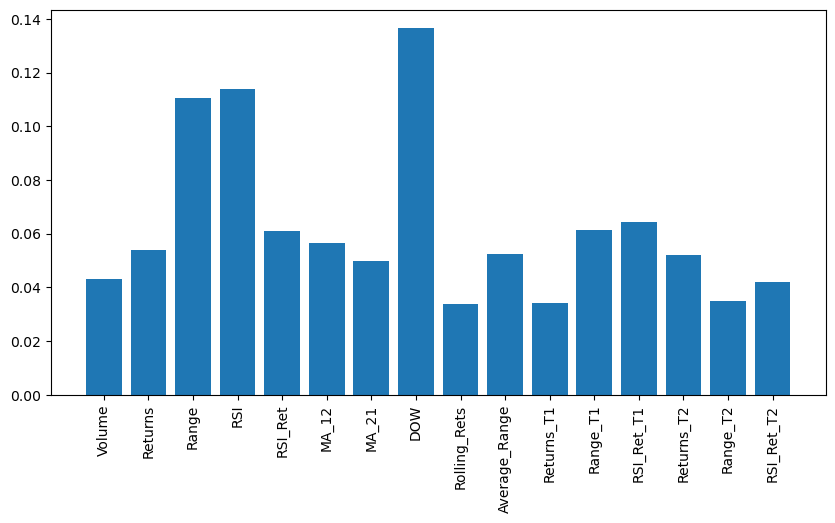

In [39]:
# Plot feature importance
fig = plt.figure(figsize=(10, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_

plt.bar([x for x in range(len(importance_features))], importance_features)
plt.xticks([x for x in range(len(importance_features))], importance_labels, rotation='vertical')
plt.show()

In [40]:
# Sekect best features
mean_feature_importance = np.mean(importance_features)
i = 0
recommended_features_labels = []
recommended_feature_scores = []

for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_features_labels.append(importance_labels[i])
        recommended_feature_scores.append(fi)
    i += 1

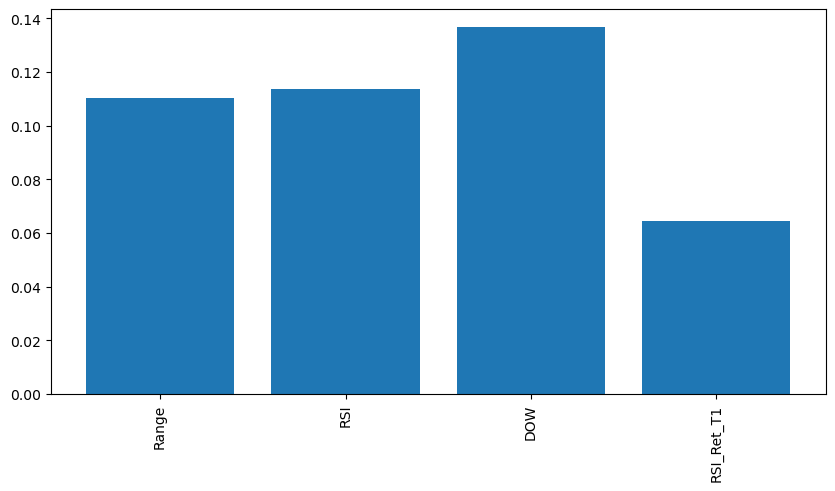

In [41]:
# Plot best features
fig = plt.figure(figsize=(10, 5))
plt.bar([x for x in range(len(recommended_feature_scores))], recommended_feature_scores)
plt.xticks([x for x in range(len(recommended_feature_scores))], recommended_features_labels, rotation='vertical')
plt.show()